# SIESTA: Statistical matchIng between rEal and Synthetic sTellar populAtions

In this Notebook, you will generate all the necessary inputs for running the `SIESTA` code. 

Run and fill all blocks in this Notebook for generating your inputs. Your choices will only be registered **at the last block**, so remember to run it after you've made your decisions. 

## First steps

Let's start by importing the relevant libraries. We will also initialize the ``inputs`` dictionary, which you will fill with several parameters for the execution of the `SIESTA` code throughout this Notebook. Start by running the following block without editing it. 

In [1]:
#Import libraries
import importlib
import sys ; sys.path.append('modules')
import Initialization
import matplotlib.pyplot as plt
%matplotlib widget
inputs = {}

Now, you must define some parameters:

- `Cluster_path`: the path for a decontaminated catalog that contains the data for a star cluster you are interested in analyzing. Must be a FITS file with the HDU in the position `[1]`;
- `Grid_path`: the path for a directory with a set of PARSEC-COLIBRI isochrones, saved individually, with the proper naming convention;
- `Project_name`: a name for your project;
- `ObsCatalogColumns`: Information regarding the name of the columns in your decontaminated catalog:
    - `MagBand`: column with the magnitudes used in the color-magnitude diagram (CMD),
    - `errorMagBand`: uncertainties of the previous column,
    - `ColorBand1`,`errorColorBand1`,`ColorBand2`,`errorColorBand2`: columns with the magnitudes (and uncertainties) of the bands correspoding to the color in the CMD. The color will be evaluated as `ColorBand1 - ColorBand2`,
    - `MembershipProbability`: column with the membership probabilities;
    - `MembershipMask`: column masking non-members: should contain 0 for non-members and any other value, between 0 and 1 for members. Can be the same as the `MembershipProbability` column.

Please fill the following block with this information and run it.

In [2]:
#Choose a path for a decontaminated VISCACHA catalog
inputs['Cluster_path'] = '../../Pesquisa/Doutorado/WorkSpace/Completeness/Milone+2023HST/projects/L113/catalog.fits'
#'../../Completeness/Milone+2023HST/projects/L114_4/catalog.fit'
#Choose a path for a PARSEC isochrone grid
inputs['Grid_path'] = '../../Pesquisa/Doutorado/WorkSpace/StellarEvolutionModels/PARSECv3p7_IsochronesUpToEAGB'
#Give a name for the project
inputs['Project_name'] = 'L113'
#Information about column names in the decontaminated catalog
inputs['ObsCatalogColumns'] = { 'MagBand' : 'V',
                                'errorMagBand': 'E_V',
                                'ColorBand1' : 'V',
                                'errorColorBand1': 'E_V',
                                'ColorBand2': 'I',
                                'errorColorBand2': 'E_I',
                                'MembershipProbability': 'PROB_VI',
                                'MembershipMask': 'MEMB_VI'
                              }
#Import clusterCMD
importlib.reload(Initialization)
clusterCMDraw,isochroneIndex = Initialization.ImportData(inputs)

WARNING! There is already a project with this name. Check before continuing


## Observed CMD stellar distribution

In this section, our goal will be to evaluate the distribution of cluster stars in the CMD. Before we do that, however, we'll need to add some filters for the population.

1. **Photometric_limit:** the maximum magnitude we shall consider in our analysis. Isochrones usually go much deeper than the typical photometric limit of our data. To avoid spending resources sampling the lower Main Sequence, we define a photometric limit from which we will start sampling. This limit could be the maximum magnitude of your data. You can also eliminate some stars where the distribution becomes too incomplete. Don't worry about leaving some "excess" where there aren't any stars for generating the synthetic CMDs (to account for binaries or photometric errors, for instance): we already do that in the code. 
2. **Outlier removal:** we consider outliers stars that are too far away from the overall distribution in the CMD. Even after the decontamination, some of these may still end up in the CMD. Usually, synthetic CMDs are unable to reproduce those stars, therefore, removing them restricts the color and magnitude ranges we will investigate, which improves the computational cost, while not impacting on the final parameters. 
3. **Membership limit:** you may want to remove some stars whose membership probability is too small.

In the following block, you can select the photometric and membership limits with the `Photometric_limit` and `Minimum_membership` parameters. The photometric limit should be in the same band as `MagBand`, that you defined earlier. For outlier removal, we evaluate the distance¹ of each star to its $k$-th neighbor in the CMD and remove the $n$ more distant stars². You'll select $k$ and $n$ in the next block, with the `Kth-neighbor` and `Outlier_num` parameters, respectively. 

Notice that, in the plots, we do not remove stars below the photometric limit at this point. We will perform that when evaluating the actual histograms since we can also consider the effect of photometric errors of these stars in the overall distribution.

The figure produced in the next block represents the filtration process described above. The first panel shows cluster members in the CMD, colored by their distance to their $k$-th neighbor. Outliers appear in pink, and the pink x  marks the next star that will be removed if you increase the outlier number by 1. In this panel (and all the following), the selected photometric limit is shown as a dashed line. The middle panel shows the CMD with the outliers removed, with the stars now colored by their membership probabilities. Stars below the chosen limit appear in red. Finally, the right panel displays the filtered CMD.

    ¹The distance is evaluated using colors and magnitudes normalized by their respective variances to account for the difference in ranges of these two quantities. 
    ²Sometimes there are pairs of outliers, so it's not always desirable to use the closest neighbor.

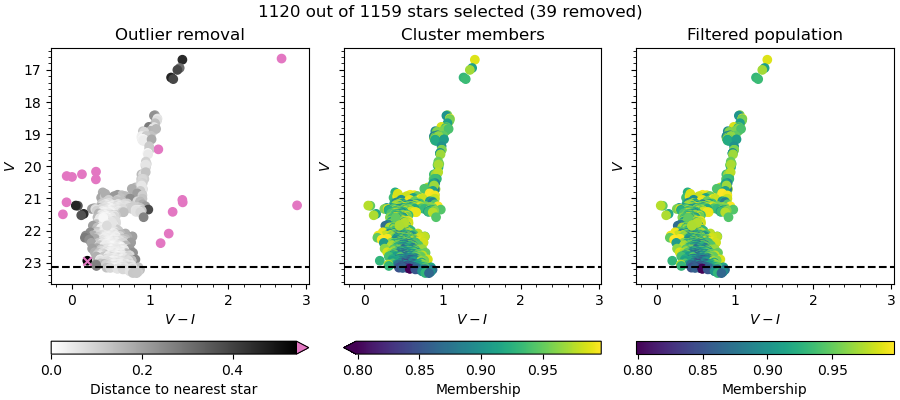

In [3]:
#Photometric limit
inputs['Photometric_limit'] = 23.15
#K-th neihbor to be used in the outlier distance evaluation
inputs['Kth-neighbor'] =2
#Number of outliers to
inputs['Outlier_num'] =15
inputs['Minimum_membership'] = 0
#Check CMD
try: plt.close(figCheckCMD) 
except: ''
importlib.reload(Initialization)
figCheckCMD,clusterCMD = Initialization.CheckCMD(clusterCMDraw,inputs)

Now, you will define the binning that will be used for creating the Hess diagrams. Use the `Color_width` and `Mag_width` parameters to define the widths of your bins in color and magnitude. Alternatively, you can leave those parameters as empty strings `''`. In that case, we will use the optimal binning method proposed by Knuth, 2006 to suggest the widhts for you. 

We stress, however, that those are only suggestions! The "optimal" binnining will often fail to constrain critical features of your CMD. For instance, it may leave too much space for bins in the Red Clump or the Main Sequence turn-off, which can compromise your fits. Try to identify critical regions of your CMD and choose a binning that frame them as best as possible.

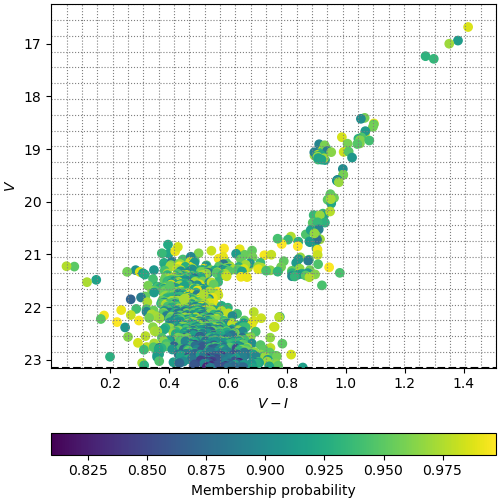

In [4]:
#Custom factor in color
inputs['Color_width'] = 0.052
inputs['Mag_width'] = 0.3
try: plt.close(figBins) 
except: ''
importlib.reload(Initialization)
figBins = Initialization.ClusterBinning(clusterCMD,inputs)

With the binning decided, we will now evaluate the Hess diagram of the observed CMD using a two-dimensional histogram. We will use the same binning for the synthetic populations as well. In principle, we could evaluate the histogram directly: by counting the number of stars in each bin. However, we should remember that the magnitude measurements of each star have uncertainties. It's important to consider how the associated errors affect the distribution of stars in the CMD, 

To achieve that, Instead of evaluating the distribution of stars using only the observed colors and magnitudes, we consider a new distribution of size $f \times N$, where $N$ is the size of the original population size and $F$ is what we call **fillling factor**. In this distribution, each star produces (besides itself) $f-1$ new stars, whose positions in the diagram correspond to the ones determined by the original star magnitudes but added with a Gaussian noise proportional to the photometric errors in each band. After that, we renormalize the counts at each bin to the original population size. Doing this is equivalent to generating $f-1$ new populations, adding noise to each one, and averaging them all.

In the next block, select a `Filling_factor` $f\geq1$. You can try different values until you stop seeing variations in the final distribution that occur due to the stochasticity of the process of "filling" the data. Don't worry about choosing large values for $f$ (1,000 to 10,000 or more) since it won't impact the performance of the `SIESTA` code, as this is the only time we will perform the filling. Of course, running the next block with huge values for $f$, especially for populous clusters, may take some time, so take that into account as well. 

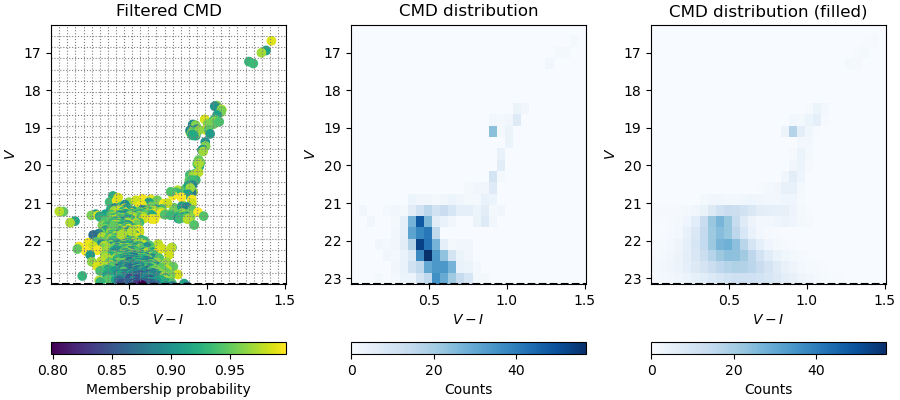

In [5]:
#Number of random representations of original data to calculate densities
inputs['Filling_factor']  = 10000
#Density maps
importlib.reload(Initialization)
try: plt.close(figClusterDensity)
except: ''
figClusterDensity,clusterCMD,clusterCMDf,ClusterGrid  = Initialization.ClusterDensity(clusterCMD,inputs)

## Synthetic Population parameters

We will now focus on the parameters necessary for generating the synthetic populations. During the MCMC sampling, the `SIESTA` code generates synthetic populations dynamically for each trial combination of age, metallicity, distance, color excess/extinction coefficient, and binary fraction. The process includes:

1. **Isochrone selection:** given a metallicity and $\log Age$ pair, we select the closest available PARSEC-COLIBRI isochrone in the specified grid. We then displace the isochrone's magnitudes according to the distance and extinction parameter provided.

2. **IMF Sampling:** from the isochrone, we sample the (initial) masses using the Initial Mass Function proposed by Kroupa, 2001. We only consider the portion of the isochrone brighter than the photometric limit, plus one magnitude, to account for the effect of the photometric errors and binarity.

3. **Binarity:** we convert a fraction of the population into non-resolved binaries by sampling a second star whose (initial) mass $M_2$ is in the interval $qM_1\leq M_2 \leq M_1$ ($M_1$ is the mass of the first star). We then replace the original star magnitudes with the combined magnitudes of the pair. The minimum mass fraction $q$ is defined so that the binaries added to the population are not too similar to single stars, which occurs when the mass of the companion is too small. Once we add the photometric errors, those binaries would not affect the overall distribution in the CMD.

4. **Completeness:**  we remove stars from the population using completeness criteria based on the cluster we aim to characterize. In the current implementation, this corresponds to a Fermi-function completeness curve (completeness as a function of the magnitude in a certain band).

5. **Photometric error:** we add some Gaussian noise to the sampled magnitudes following error curves (uncertainty as a function of the magnitudes) fitted to the star cluster of interest. 

We finally remove synthetic stars still dimmer than the photometric limit and evaluate their distribution in the same bins used for the observed star cluster. 

You will begin by setting the parameters for importing the isochrones. Simillarly to what was done for the decontaminated catalog, you will use the `IsochroneColumns` parameter to define the name of the columns on the isochrone files:
    - `MagBand`: column with the magnitudes used in the color-magnitude diagram (CMD),
    - `ColorBand1`,`ColorBand2`: columns with the magnitudes (and uncertainties) of the bands correspoding to the color in the CMD. The color will be evaluated as `ColorBand1 - ColorBand2`.

`MagBand`, `ColorBand1`, and `ColorBand2` must assign the same bands in the isochrone file and in the decontaminated catalog (simply adjusting the names as they appear in each file).

Additionally, we must set the relation between different extinction coefficients and color excesses, derived from an extinction law. You may want to evaluate the interstellar extinction using its coefficient in the `MagBand` band ($A_{MagBand}$), its color excess $E(ColorBand1 - ColorBand2)$ or using another parameter altogheter. In either case, you must provide the relations between these parameters. 

If we define your desired extinction parameter as $ExtinctionParameter$, we can express its relation to the extinction coefficient in a certain band $A_{Band}$ as:

$$ A_{Band}= \alpha_{Band} \times ExtinctionParameter $$

Please, provide the corresponding $\alpha_{Band}$ for your previous choices of  `MagBand`, `ColorBand1`, and `ColorBand2` using the parameters `MagCorrection`, `ColorCorrection1`, `ColorCorrection2` under `ExtinctionLaw`. You may also register as string defining your adopted `ExtinctionParameter`.

After defining these parameters please specify a metallicity (`mh`), an age (in logarithmic form, `logage`), a distance (`d`, in kiloparsecs) and a value for your extinction paramer (`extpar`). We will use them to import an isochrone and plot it over the decontaminated catalog. This will serve as a test for your previous choices. They may also be useful, as an initial visual isochrone fit that you could use later, for defining the starting positions of the walkers for the MCMC sampling.


Extinction parameter (E(B-V)): 0.1
	 Extinction coefficient in the Vmag band: 0.3077982779827799
	 Extinction coefficient in the Vmag band: 0.3077982779827799
	 Extinction coefficient in the Imag band: 0.18417281672816732
	 Color excess coefficient in Vmag-Imag: 0.012362546125461261


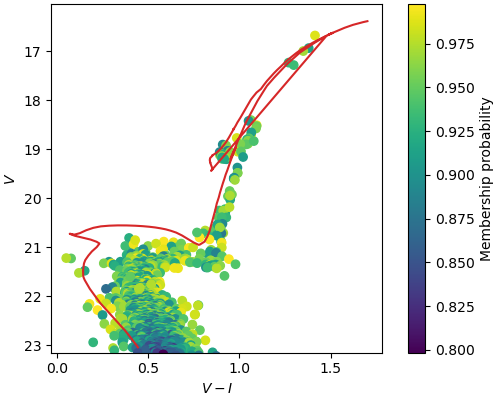

In [6]:
#Column names for isochrone files
inputs['IsochroneColumns'] = { 'MagBand' : 'Vmag',
                               'ColorBand1' : 'Vmag',
                               'ColorBand2': 'Imag',
                                }

#Extinction law
inputs['ExtinctionLaw'] = { 'ExtinctionParameter':'E(B-V)',
                            'MagCorrection':1.00096/(1.32616-1.00096),
                            'ColorCorrection1' : 1.00096/(1.32616-1.00096),
                            'ColorCorrection2' : 0.59893/(1.32616-1.00096),
                          }

#Isochrone parameters
mh = -1
logage = 9.3
d = 60
extpar = 0.1

#Plot isochrone
try: plt.close(figIsochrone)
except: ''
importlib.reload(Initialization)
figIsochrone = Initialization.ImportIsochrone(clusterCMD,inputs,mh,logage,d,extpar,isochroneIndex[0])


Now, you shall inform the completeness parameters of the star cluster. These correspond to a Fermi function fitted for the observed cluster data. This function consists of the expression:

$$ \text{Completeness}(mag) = \dfrac{1}{1+e^{\beta(mag-mag_F)}}$$

Where $mag$ is the magnitude and $\beta$ and $mag_F$ are the fitted parameters. You can provide them in the following block with the `Beta` and `FermiMag` parameters, respectively. You must also provide the `Band` used for the fitted Fermi funtion.  This band must be one of the bands you specified earlier in this Notebook for the decontaminated catalog. 

As a reference, you'll see a plot of the histogram of the filtered member's magnitudes and the expected distribution if the cluster were complete. To do that, we assume that each star contributes with $\text{Completeness}^{-1}$ to the distribution. 

Should you not want to include completeness, you can write ``inf`` for the $\beta$ parameter and choose a value for $I_F$ greater than the maximum I band magnitude of the population, which will set the completeness to 1 over all relevant magnitudes.


Number of members: 1120.0
Completeness corrected number: ~1442
	(every star counts as 1/completeness)
Expected loss: ~28.77%


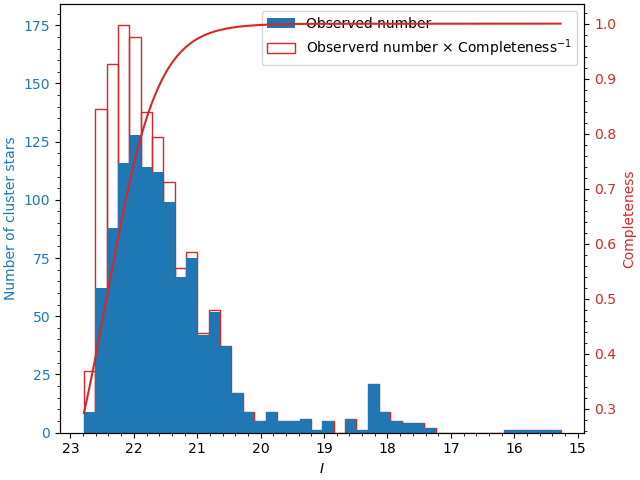

In [7]:
from numpy import inf
inputs['Completeness_Fermi'] = {
    'FermiMag': 22.431238135097594,
    'Beta':2.486120986378649,
    'Band':'I'
}

#Completeness
try: plt.close(figCompleteness)
except: ''
importlib.reload(Initialization)
figCompleteness = Initialization.FermiCompleteness(clusterCMD,inputs)

Next, we will fit exponential functions to the members' error curves. Those curves correspond to the obtained photometric error as a function of the measured magnitudes in each band. Usually, an exponential function will conform nicely to the data. In some cases, however, there might be too much dispersion to find a good fit. These typically occur in large clusters. In those scenarios, we advise you to smooth the observational error curves by using a rolling quantile on the data, which should solve the issue at the cost of some data points at the edges of the curves. 

In the following block, select how many points you want to use for the rolling quantile for each band using the `MagBand_points_for_rolling`, `ColorBand1_points_for_rolling`, and `ColorBand2_points_for_rolling` parameters. They refer to the bands you defined earlier in the Notebook. Additionaly, use the `MagBand_quantile`, `ColorBand1_quantile` and `ColorBand2_quantile` to set the quantile that will be used. Choosing 0.5, for instance, means you'll be evaluating the moving median. If you do not want to apply a rolling quantile, simply set the `_points_for_rolling` parameters to 1.

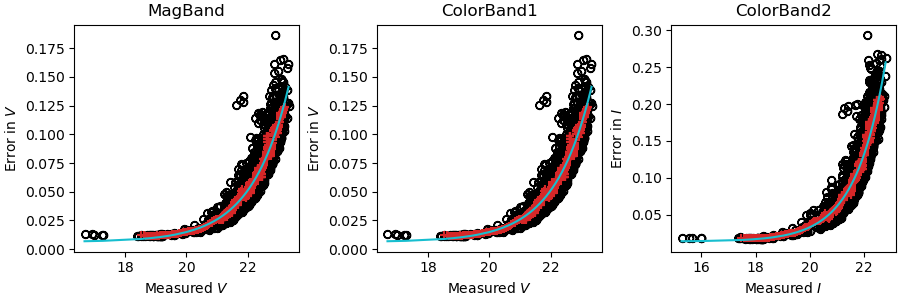

In [8]:
#Coefficients for error function
inputs['Fit_error_curve']  = True
inputs['MagBand_points_rolling_mean'] = 30
inputs['ColorBand1_points_rolling_mean'] = 30
inputs['ColorBand2_points_rolling_mean'] = 30
inputs['MagBand_quantile'] = 0.5
inputs['ColorBand1_quantile'] = 0.5
inputs['ColorBand2_quantile'] = 0.5
#Evaluate errors
try: plt.close(figErrorCurve)
except: ''
importlib.reload(Initialization)
figErrorCurve = Initialization.ErrorCurve(clusterCMD,inputs)

Finally, you will set some parameters for generating the synthetic populations:

- `Initial_population_size`: the proposed number of stars in the synthetic population;
- `Companion_min_mass_fraction`: minimum mass fraction for companion stars in non-resolved binary systems;
- `Seed`: random seed for the pseudo number generators used for creating the synthetic populations.

When choosing the initial population size, consider that we generate the populations a magnitude beyond the photometric limit and remove stars following according to a completeness criterium. Therefore, the final number of synthetic stars in the population will be smaller than this parameter. 

You don't need to generate synthetic populations the same size as the observed cluster. Actually, it is a better idea to create populations with an order of magnitude or two more stars than the cluster, which will reduce the stochasticity in the evaluation of the histogram. We will renormalize the histogram to the cluster size afterward anyway. Good choices for the initial population size are between *20 to 50 thousand synthetic stars*. **Try different combinations until you stop seeing variations in the histograms**. Keep in mind that, differently than the filling factor,  **this size of the synthetic populations will affect the performance of the MCMC sampling**, since `SIESTA` generates synthetic populations dynamically during this phase.

For binarity, our goal is to generate non-resolved systems in regions of the CMD where single stars wouldn't be present, even considering the photometric errors. Increasing the minimum mass fraction will distance the non-resolved binaries from the single stars. If this parameter is too high, this may lead to discontinuities in the CMD. The current version of `SIESTA` uses the binary fraction as a free parameter, but you still need to set the minimum mass fraction of the companion. 

Finally, the choice of the seed is not a critical parameter since the synthetic populations should be large enough to minimize stochastical effects. Fixing the seed creates smoother transitions between different populations, which is important for the MCMC sampling and also ensures that you can reproduce the populations used in the fitting process, if necessary.

When running the following block you'll see an example of a synthetic population generated with the same parameters you've defined earlier (you will also need to set a certain binary fraction with `binF`).

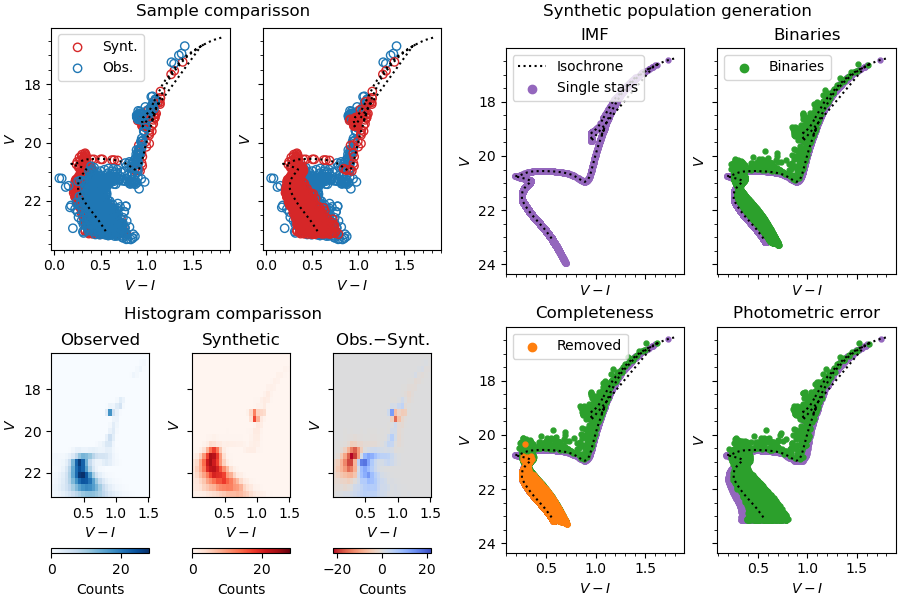

In [9]:
#Initial size of the population
inputs['Initial_population_size'] = 50000
#Minimum mass fraction for binary star
inputs['Companion_min_mass_fraction'] = 0.6
#Seed for synthetic population
inputs['Seed'] = 1
#Parameters for the synthetic population (not important for the input generation)
binF = 0.2
#See synthetic population
importlib.reload(Initialization)
try: plt.close(figSyntheticPopulation)
except: ''
figSyntheticPopulation = Initialization.SyntheticPopulation(clusterCMD,ClusterGrid,inputs,isochroneIndex[0],
                                                            [mh,logage,d,extpar,binF])


## MCMC parameters

We've reached the final section of our Notebook. Now, you'll choose some of the parameters for the MCMC sampling employed for characterizing the stellar population you're studying. We are interested in maximizing the posterior probability $ \mathcal{P}$, i.e., the probability of the stellar population having a given set of parameters conditioned to the observed CMD. Bayes's theorem shows that this probability is proportional to the product of a *prior* $\mathcal{p}$ and a likelihood  $\mathcal{L}$ distribution:

$$ \mathcal{P}\text{(Age,[M/H],d,E(B-V)|CMD)}\propto\mathcal{p}{(Age,[M/H],d,E(B-V)}\times \mathcal{L}\text{(CMD|Age,[M/H],d,E(B-V))} $$

The **likelihood** is the probability of a stellar population with the same set of parameters presenting the observed CMD. The synthetic populations allow us to predict the CMD of a stellar population with a given age, metallicity, distance, and reddening. We evaluate how likely it is for the observed CMD to be consistent with this prediction using the function presented in Tremmel et al., 2013, based on the Poisson probability distribution of the number of counts in each bin of the histograms we've calculated. 

The ***priors***, in turn, are the probability distribution of each parameter unconditioned by the observed CMD. These can refer, for instance, to expectations on the cluster distance or metallicity, based astrometrical or spectroscopic characterizations. *Priors* can also be set in more practical terms: your grid of isochrones will be limited in age and metallicity; discances, extinction parameters, and binary fractions must never be negative, etc. Keep those limitations in mind when defining your *priors*.

We'll start by defining the *priors* to be used in the MCMC sampling. You must set individual priors for each of the parameters, with three different options:

- ``Box``: all values within a given range will be equally possible. Outside this range, however, the probability is set to 0.
- ``Gaussian``: the prior will follow a normal distribution centered around a given value, with a given standard deviation.
- ``LogNormal``: the prior will follow a [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution)  parameterized by $\mu$ and $\sigma$.  

The ``Box`` prior is useful for restricting the parameter space within a range of reasonable values. The ``Gaussian`` prior is proper for parameters with an independent measurement (distance, or metallicity come to mind). Finally, ``LogNormal`` is available mainly for the binary fraction. Donada et al., 2023 found that the binary fraction of Galactic open clusters (with a minimum mass fraction of 0.60) follow a log-normal distribution with $\mu\approx-1.715$, and $\sigma\approx0.5$.

When selecting the *priors*, you must inform additional parameters: the minimum and maximum values of non-zero probability for ``Box``, the mean and standard deviation for ``Gaussian``, and $\mu$ and $\sigma$ for ``LogNormal``. For ``Gaussian`` and ``LogNormal`` *priors* you should also specify minimum and maximum limits for the parameters. Those are convenient when hard limits are still necessary (for practical reasons, as mentioned earlier)

Insert those parameters in the adequate space in the box below, using a list syntax:
 
- If you choose ``'Box'`` for ``Type``, specify `[min_limit, max_limit]` for `Parameters`.
- If you choose ``'Gaussian'`` for ``Type``, specify `[mean, std_deviation, min_limit, max_limit]` for `Parameters`.
- If you choose ``'LogNormal'`` for ``Type``, specify `[mu, sigma, min_limit, max_limit]` for `Parameters`.

After filling in the values in the next block, you'll see the plot of the chosen functions. Notice that we do not normalize the area of the *priors* to 1, which is not necessary for maximizing the *posterior*

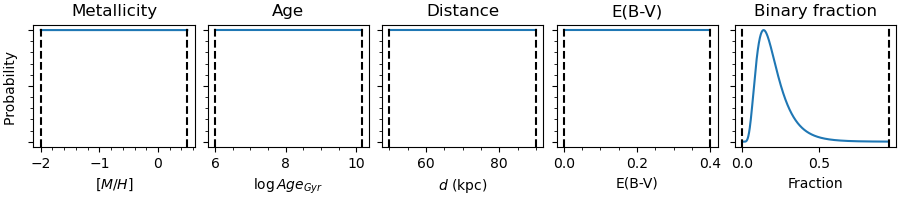

In [10]:
inputs['Priors'] = {'Metallicity' : {'Type' : 'Box',
                                    'Parameters': [-2,0.5]
                                     },
                   'Age':          {'Type' : 'Box',
                                    'Parameters': [6,10.15]
                                     },
                   'Distance':     {'Type' : 'Box',
                                    'Parameters': [50,90]
                                     },
                   'ExtinctionPar':  {'Type' : 'Box',
                                    'Parameters': [0.0,0.4]
                                     },
                   'BinFraction': {'Type' : 'LogNormal',
                                   'Parameters': [-1.715,0.5,0.00,0.95]
                                   }}

#Display priors
importlib.reload(Initialization)
try: plt.close(figSyntheticPopulation)
except: ''
figPriors = Initialization.Priors(inputs,isochroneIndex[1],isochroneIndex[2])

The last parameters you must fill in refer to the MCMC sampling. Under `Walkers_start` you will define the initial positions and the number of walkers the `SIESTA` code will use for the MCMC sampling. A walker is defined by its position in the parameter space, given by its age, metallicity, distance, color excess, and binary fraction. We initialize walkers in a hypercube defined by your choice of initial and final values (``Minimum` and `Maximum`) for each parameter and the number of values in each direction (`Number`).

When running the MCMC sampling, walkers will travel in the parameter space, changing their positions randomly with a probability that depends on the *posterior* distribution. The acceptance fraction is the fraction of walkers that successfully changed positions at each iteration. Developers of ``emcee`` suggest that the **acceptance fraction should be between 0.2 and 0.5**. You can monitor the fraction when running the SIESTA code. Usually, you can increase this value by using more walkers in the MCMC sampling. Keep in mind, however, that increasing the number of walkers will impact the performance of the SIESTA code, so avoid doing so when not necessary. Usually around 100 walkers will suffice, but this can vary deppending on the cluster.

The developers of ``emcee`` also suggest that we **initialize the walkers tightly, close to the expected solution**. If you set walkers too far apart, they may find some local maxima of the posterior distribution and get "stuck." If this happens, the acceptance fraction will drop steeply, and the chain will not converge.

The `SIESTA` code uses convergence criteria suggested by the developers of ``emcee`` to decide when to stop the sampling. You should also choose a maximum number of iterations to avoid running problematic chains endlessly by setting `MaxIterations`. 

Total number of walkers: 108
Maximum size of the chain: 2160000


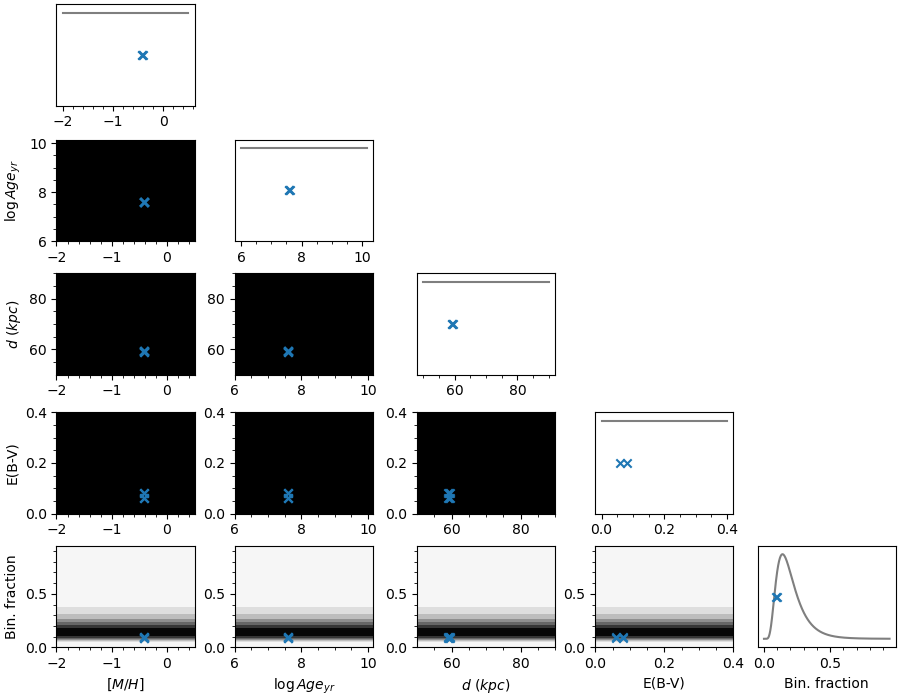

In [11]:
#Maximum number of iterations
#Total number of MCMC iterations
inputs['Max_iterations'] = 20000
#Information about the initial positions for the walkers

inputs['Walkers_start'] ={'Metallicity' : {'Minimum' : -0.41,
                                           'Maximum' : -0.42,
                                           'Number' : 3
                                             },
                           'Age':         {'Minimum' : 7.59,
                                           'Maximum' : 7.61,
                                           'Number' : 3
                                             },
                           'Distance':    {'Minimum' : 59,
                                           'Maximum' : 59.5,
                                           'Number' : 3
                                             },
                           'ExtinctionPar': {'Minimum' : 0.06,
                                           'Maximum' : 0.08,
                                           'Number' : 2
                                             },
                           'BinFraction': {'Minimum' : 0.09,
                                           'Maximum' : 0.10,
                                           'Number' : 2
                                             }}



#See starting walkers
importlib.reload(Initialization)

try: plt.close(figStartingWalkers)
except: ''
figStartingWalkers = Initialization.StartingWalkers(inputs,isochroneIndex[1],isochroneIndex[2])


In [12]:
importlib.reload(Initialization)
Initialization.SaveAll(inputs,
                       [figCheckCMD,figBins,figClusterDensity,figIsochrone,figErrorCurve,figCompleteness,figSyntheticPopulation,figPriors,figStartingWalkers],
                        clusterCMD,ClusterGrid)

Inputs saved! Check files in projects/L113
	 inputs.dat and inputs.pkl contain the choosen inputs
	 inputs.pdf contains the corresponding figures
	 FilteredCMD.dat contains the filtered cluster CMD
	 CMDgrid.dat contains the grid with the cluster distribution


# References

> Bressan, Alessandro, et al. "PARSEC: stellar tracks and isochrones with the PAdova and TRieste Stellar Evolution Code." Monthly Notices of the Royal Astronomical Society 427.1 (2012): 127-145.
>
> Foreman-Mackey, Daniel, et al. "emcee: the MCMC hammer." Publications of the Astronomical Society of the Pacific 125.925 (2013): 306.
>
> Knuth, Kevin H. "Optimal data-based binning for histograms." arXiv preprint physics/0605197 (2006).
>
> Kroupa, Pavel. "On the variation of the initial mass function." Monthly Notices of the Royal Astronomical Society 322.2 (2001): 231-246.
>
> Tremmel, Michael, et al. "Modeling the redshift evolution of the normal galaxy x-ray luminosity function." The Astrophysical Journal 766.1 (2013): 19.